In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='2'

import math
import torch
import numpy
import timm
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms


#
# Stochastic inplace weight (SIW) dropout is experimented with in this notebook.
#
# Antorbus

In [2]:
torch.cuda.is_available()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize([0.49, 0.48 ,0.45], [0.25,0.24,0.26])])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
prlist=[]
arch='vit_tiny_patch16_224'
model = timm.create_model(arch)
for name, param in model.named_parameters():
    if param.requires_grad and param.ndim==2:
        prlist.append(name)


In [73]:
prlist #List containing the names of the weights of all the fully connected layers in VIT 

['blocks.0.attn.qkv.weight',
 'blocks.0.attn.proj.weight',
 'blocks.0.mlp.fc1.weight',
 'blocks.0.mlp.fc2.weight',
 'blocks.1.attn.qkv.weight',
 'blocks.1.attn.proj.weight',
 'blocks.1.mlp.fc1.weight',
 'blocks.1.mlp.fc2.weight',
 'blocks.2.attn.qkv.weight',
 'blocks.2.attn.proj.weight',
 'blocks.2.mlp.fc1.weight',
 'blocks.2.mlp.fc2.weight',
 'blocks.3.attn.qkv.weight',
 'blocks.3.attn.proj.weight',
 'blocks.3.mlp.fc1.weight',
 'blocks.3.mlp.fc2.weight',
 'blocks.4.attn.qkv.weight',
 'blocks.4.attn.proj.weight',
 'blocks.4.mlp.fc1.weight',
 'blocks.4.mlp.fc2.weight',
 'blocks.5.attn.qkv.weight',
 'blocks.5.attn.proj.weight',
 'blocks.5.mlp.fc1.weight',
 'blocks.5.mlp.fc2.weight',
 'blocks.6.attn.qkv.weight',
 'blocks.6.attn.proj.weight',
 'blocks.6.mlp.fc1.weight',
 'blocks.6.mlp.fc2.weight',
 'blocks.7.attn.qkv.weight',
 'blocks.7.attn.proj.weight',
 'blocks.7.mlp.fc1.weight',
 'blocks.7.mlp.fc2.weight',
 'blocks.8.attn.qkv.weight',
 'blocks.8.attn.proj.weight',
 'blocks.8.mlp.fc1.we

In [6]:
# SIW dropout (shown in this function) randomly sets a specified percentage of weights in a layer to zero and 
# scales the rest of the weights accordingly (to make them smaller)
def weight_change_v1(net, p_dropout=0.02): 
    with torch.no_grad():
        for name, param in net.named_parameters():
            if name in prlist:
                param /= (1./(1.-p_dropout)) 
                # Other scaling methods need to be tested such as:
                # /= (1./ math.sqrt(1.-p_dropout)) <--- not tested
                # *= (1./(1.-p_dropout)) <--- this scaling hinders performance 
                # *= (1./(1.- math.sqrt(p_dropout))) <--- not tested 
                # *= 1 <--- tested only on smaller networks
                n_weights = param.numel()
                n_weights_to_change = math.ceil(n_weights * p_dropout)
                idx = torch.randint(n_weights,(n_weights_to_change,))
                param_flattened = param.flatten()
                param_flattened[idx]=0

In [7]:
def test(model, criterion):
    with torch.no_grad():
        model.eval()
        correct, total, v_loss = 0, 0, 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            v_loss += loss.item()*data.size(0)
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        v_loss = v_loss/total
        acc=correct/total
        print(f'Validation accuracy: {acc*100:.3f}% Valid loss: {v_loss:.6f}\n')
    return float(acc), v_loss

In [8]:
def train(model, epochs, optimizer, criterion, p_SIWdropout = None, SIWdropout_rate = 0):
    model.to(device)
    results = {
        'Train_loss' : [],
        'Valid_loss' : [],
        'Valid_accuracy' : []
    }
    for epoch in range(1, epochs+1):
        train_loss = 0.0

        if p_SIWdropout and  epoch%SIWdropout_rate == 0:
            weight_change_v1(model, p_dropout= p_SIWdropout)
            print('Performing SIW dropout...')

        model.train()
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(train_loader.dataset)
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')
        acc, v_loss = test(model, criterion)
        results['Train_loss'].append(train_loss)
        results['Valid_loss'].append(v_loss)
        results['Valid_accuracy'].append(acc)
    return results

In [9]:
def experiment(p_SIWdropout = None, SIWdropout_rate = 0, num_epochs=20, learning_rate = 0.001):
    net = timm.create_model(arch, pretrained=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    # Diffrent optimizers and learning rates should be tested 
    # Networks that are not pretrained should also be tested 
    criterion = torch.nn.CrossEntropyLoss()
    return train(net, num_epochs, optimizer, criterion, p_SIWdropout, SIWdropout_rate)

In [10]:
#Training networks with and without SIW dropout 
results_normal = experiment() 
results_SIW_001_every1epoch = experiment(.001, 1)
results_SIW_1_every7epoch = experiment(.1, 7)
results_SIW_05_every3epoch= experiment(.05, 3)
results_SIW_05_every2epoch= experiment(.05, 2)
results_SIW_02_every1epoch= experiment(.02, 1)
results_SIW_0001_every1epoch= experiment(.0001, 1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.97it/s]

Epoch: 1 	Training Loss: 1.431138


Validation accuracy: 56.890% Valid loss: 1.285334



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 2 	Training Loss: 0.981902


Validation accuracy: 69.270% Valid loss: 0.870478



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.16it/s]

Epoch: 3 	Training Loss: 0.826590


Validation accuracy: 72.470% Valid loss: 0.788617



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.94it/s]

Epoch: 4 	Training Loss: 0.718569


Validation accuracy: 75.330% Valid loss: 0.701471



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.72it/s]

Epoch: 5 	Training Loss: 0.630484


Validation accuracy: 78.680% Valid loss: 0.615964



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.02it/s]

Epoch: 6 	Training Loss: 0.561254


Validation accuracy: 78.200% Valid loss: 0.623955



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 7 	Training Loss: 0.498493


Validation accuracy: 79.950% Valid loss: 0.568720



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 8 	Training Loss: 0.447311


Validation accuracy: 79.660% Valid loss: 0.583156



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.38it/s]

Epoch: 9 	Training Loss: 0.396671


Validation accuracy: 79.750% Valid loss: 0.603363



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.98it/s]

Epoch: 10 	Training Loss: 0.356697


Validation accuracy: 79.430% Valid loss: 0.602738



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.45it/s]

Epoch: 11 	Training Loss: 0.318945


Validation accuracy: 80.780% Valid loss: 0.575781



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.05it/s]

Epoch: 12 	Training Loss: 0.283392


Validation accuracy: 81.980% Valid loss: 0.557366



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.56it/s]

Epoch: 13 	Training Loss: 0.253035


Validation accuracy: 81.960% Valid loss: 0.567759



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.85it/s]

Epoch: 14 	Training Loss: 0.227579


Validation accuracy: 81.660% Valid loss: 0.588961



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 15 	Training Loss: 0.200754


Validation accuracy: 80.700% Valid loss: 0.640110



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.55it/s]

Epoch: 16 	Training Loss: 0.186135


Validation accuracy: 80.930% Valid loss: 0.647280



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.10it/s]

Epoch: 17 	Training Loss: 0.166396


Validation accuracy: 82.380% Valid loss: 0.645024



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.63it/s]

Epoch: 18 	Training Loss: 0.151673


Validation accuracy: 81.980% Valid loss: 0.668026



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.25it/s]

Epoch: 19 	Training Loss: 0.146850


Validation accuracy: 82.770% Valid loss: 0.605053



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.57it/s]

Epoch: 20 	Training Loss: 0.131219


Validation accuracy: 82.650% Valid loss: 0.616839

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.01it/s]

Epoch: 1 	Training Loss: 1.729252


Validation accuracy: 49.700% Valid loss: 1.348701

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.75it/s]

Epoch: 2 	Training Loss: 1.258340


Validation accuracy: 57.700% Valid loss: 1.169550

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.89it/s]

Epoch: 3 	Training Loss: 1.082382


Validation accuracy: 62.230% Valid loss: 1.047267

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.52it/s]

Epoch: 4 	Training Loss: 0.962610


Validation accuracy: 66.570% Valid loss: 0.930395

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.03it/s]

Epoch: 5 	Training Loss: 0.865682


Validation accuracy: 70.010% Valid loss: 0.853425

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.91it/s]

Epoch: 6 	Training Loss: 0.775616


Validation accuracy: 71.800% Valid loss: 0.798948

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.61it/s]

Epoch: 7 	Training Loss: 0.696825


Validation accuracy: 70.260% Valid loss: 0.880356

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.96it/s]

Epoch: 8 	Training Loss: 0.636670


Validation accuracy: 74.990% Valid loss: 0.716336

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.43it/s]

Epoch: 9 	Training Loss: 0.573525


Validation accuracy: 72.350% Valid loss: 0.815471

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.08it/s]

Epoch: 10 	Training Loss: 0.520936


Validation accuracy: 75.700% Valid loss: 0.704127

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.73it/s]

Epoch: 11 	Training Loss: 0.469033


Validation accuracy: 75.500% Valid loss: 0.722208

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.97it/s]

Epoch: 12 	Training Loss: 0.426865


Validation accuracy: 76.570% Valid loss: 0.719401

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.68it/s]

Epoch: 13 	Training Loss: 0.377412


Validation accuracy: 75.800% Valid loss: 0.752165

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.98it/s]

Epoch: 14 	Training Loss: 0.341323


Validation accuracy: 76.350% Valid loss: 0.750951

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.53it/s]

Epoch: 15 	Training Loss: 0.300337


Validation accuracy: 76.130% Valid loss: 0.755097

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 22.99it/s]

Epoch: 16 	Training Loss: 0.268467


Validation accuracy: 77.190% Valid loss: 0.746908

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.02it/s]

Epoch: 17 	Training Loss: 0.245400


Validation accuracy: 77.090% Valid loss: 0.770874

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.65it/s]

Epoch: 18 	Training Loss: 0.217469


Validation accuracy: 77.690% Valid loss: 0.797605

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.05it/s]

Epoch: 19 	Training Loss: 0.200183


Validation accuracy: 76.590% Valid loss: 0.892403

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.53it/s]

Epoch: 20 	Training Loss: 0.178592


Validation accuracy: 76.570% Valid loss: 0.898082



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.21it/s]

Epoch: 1 	Training Loss: 1.498286


Validation accuracy: 58.640% Valid loss: 1.128637



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.73it/s]

Epoch: 2 	Training Loss: 1.030687


Validation accuracy: 68.290% Valid loss: 0.921304



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.97it/s]

Epoch: 3 	Training Loss: 0.857566


Validation accuracy: 67.610% Valid loss: 0.921536



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.78it/s]

Epoch: 4 	Training Loss: 0.751490


Validation accuracy: 72.520% Valid loss: 0.771575



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.98it/s]

Epoch: 5 	Training Loss: 0.669418


Validation accuracy: 74.970% Valid loss: 0.709990



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.55it/s]

Epoch: 6 	Training Loss: 0.597251


Validation accuracy: 76.070% Valid loss: 0.684905

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.01it/s]

Epoch: 7 	Training Loss: 0.599790


Validation accuracy: 76.820% Valid loss: 0.662980



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.93it/s]

Epoch: 8 	Training Loss: 0.519022


Validation accuracy: 78.470% Valid loss: 0.615126



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.65it/s]

Epoch: 9 	Training Loss: 0.462168


Validation accuracy: 79.230% Valid loss: 0.590232



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.15it/s]

Epoch: 10 	Training Loss: 0.408758


Validation accuracy: 78.660% Valid loss: 0.619956



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 11 	Training Loss: 0.366927


Validation accuracy: 81.330% Valid loss: 0.550537



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.06it/s]

Epoch: 12 	Training Loss: 0.332234


Validation accuracy: 80.290% Valid loss: 0.592587



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.51it/s]

Epoch: 13 	Training Loss: 0.291032


Validation accuracy: 80.940% Valid loss: 0.598166

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.83it/s]

Epoch: 14 	Training Loss: 0.341408


Validation accuracy: 81.110% Valid loss: 0.604718



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.95it/s]

Epoch: 16 	Training Loss: 0.253741


Validation accuracy: 80.630% Valid loss: 0.620896



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.56it/s]

Epoch: 17 	Training Loss: 0.226021


Validation accuracy: 81.670% Valid loss: 0.595728



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.72it/s]

Epoch: 18 	Training Loss: 0.204642


Validation accuracy: 81.330% Valid loss: 0.614146



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.03it/s]

Epoch: 19 	Training Loss: 0.182882


Validation accuracy: 81.820% Valid loss: 0.617470



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.74it/s]

Epoch: 20 	Training Loss: 0.166551


Validation accuracy: 80.550% Valid loss: 0.669175



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.26it/s]

Epoch: 1 	Training Loss: 1.396420


Validation accuracy: 60.160% Valid loss: 1.116340



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:05<00:00, 23.75it/s]

Epoch: 2 	Training Loss: 0.947667


Validation accuracy: 70.850% Valid loss: 0.849599

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.76it/s]

Epoch: 3 	Training Loss: 0.810471


Validation accuracy: 73.360% Valid loss: 0.739127



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.76it/s]

Epoch: 4 	Training Loss: 0.707384


Validation accuracy: 74.550% Valid loss: 0.729136



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.45it/s]

Epoch: 5 	Training Loss: 0.617889


Validation accuracy: 77.500% Valid loss: 0.637666

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.80it/s]

Epoch: 6 	Training Loss: 0.580390


Validation accuracy: 76.730% Valid loss: 0.674055



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.25it/s]

Epoch: 7 	Training Loss: 0.517070


Validation accuracy: 79.760% Valid loss: 0.568568



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.27it/s]

Epoch: 8 	Training Loss: 0.459991


Validation accuracy: 79.900% Valid loss: 0.567346

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.76it/s]

Epoch: 9 	Training Loss: 0.441647


Validation accuracy: 81.410% Valid loss: 0.549550



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.26it/s]

Epoch: 10 	Training Loss: 0.397875


Validation accuracy: 81.400% Valid loss: 0.557253



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.22it/s]

Epoch: 11 	Training Loss: 0.346023


Validation accuracy: 81.340% Valid loss: 0.540354

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.69it/s]

Epoch: 12 	Training Loss: 0.352973


Validation accuracy: 81.690% Valid loss: 0.549794



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.08it/s]

Epoch: 13 	Training Loss: 0.303124


Validation accuracy: 82.390% Valid loss: 0.523708



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.25it/s]

Epoch: 14 	Training Loss: 0.273268


Validation accuracy: 81.780% Valid loss: 0.574236

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 15 	Training Loss: 0.285118


Validation accuracy: 81.950% Valid loss: 0.566760



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.10it/s]

Epoch: 16 	Training Loss: 0.246553


Validation accuracy: 82.410% Valid loss: 0.552426



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 17 	Training Loss: 0.219171


Validation accuracy: 82.140% Valid loss: 0.575371

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 18 	Training Loss: 0.244074


Validation accuracy: 83.110% Valid loss: 0.536766



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.42it/s]

Epoch: 19 	Training Loss: 0.202149


Validation accuracy: 82.320% Valid loss: 0.587621



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.40it/s]

Epoch: 20 	Training Loss: 0.184812


Validation accuracy: 83.360% Valid loss: 0.557273



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.47it/s]

Epoch: 1 	Training Loss: 1.413946


Validation accuracy: 61.490% Valid loss: 1.051115

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.44it/s]

Epoch: 2 	Training Loss: 1.010626


Validation accuracy: 66.490% Valid loss: 0.946658



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.31it/s]

Epoch: 3 	Training Loss: 0.829547


Validation accuracy: 72.970% Valid loss: 0.757657

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.72it/s]

Epoch: 4 	Training Loss: 0.752353


Validation accuracy: 72.890% Valid loss: 0.770044



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.30it/s]

Epoch: 5 	Training Loss: 0.651872


Validation accuracy: 76.930% Valid loss: 0.654567

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.74it/s]

Epoch: 6 	Training Loss: 0.613975


Validation accuracy: 77.710% Valid loss: 0.633724



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.40it/s]

Epoch: 7 	Training Loss: 0.538873


Validation accuracy: 77.930% Valid loss: 0.643580

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.27it/s]

Epoch: 8 	Training Loss: 0.514229


Validation accuracy: 79.090% Valid loss: 0.591075



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.62it/s]

Epoch: 9 	Training Loss: 0.450912


Validation accuracy: 78.950% Valid loss: 0.623653

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.29it/s]

Epoch: 10 	Training Loss: 0.446670


Validation accuracy: 79.540% Valid loss: 0.611608



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.30it/s]

Epoch: 11 	Training Loss: 0.386539


Validation accuracy: 80.650% Valid loss: 0.570688

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.44it/s]

Epoch: 12 	Training Loss: 0.379973


Validation accuracy: 81.020% Valid loss: 0.560688



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.22it/s]

Epoch: 13 	Training Loss: 0.329787


Validation accuracy: 80.070% Valid loss: 0.607958

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.55it/s]

Epoch: 14 	Training Loss: 0.332925


Validation accuracy: 81.440% Valid loss: 0.562013



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.54it/s]

Epoch: 15 	Training Loss: 0.289550


Validation accuracy: 81.500% Valid loss: 0.554836

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.49it/s]

Epoch: 16 	Training Loss: 0.293415


Validation accuracy: 81.300% Valid loss: 0.584475



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.39it/s]

Epoch: 17 	Training Loss: 0.257483


Validation accuracy: 82.210% Valid loss: 0.600124

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.58it/s]

Epoch: 18 	Training Loss: 0.264662


Validation accuracy: 78.160% Valid loss: 0.718294



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.51it/s]

Epoch: 19 	Training Loss: 0.229842


Validation accuracy: 82.200% Valid loss: 0.613164

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.66it/s]

Epoch: 20 	Training Loss: 0.243791


Validation accuracy: 81.960% Valid loss: 0.599597

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.08it/s]

Epoch: 1 	Training Loss: 1.680266


Validation accuracy: 49.220% Valid loss: 1.418139

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.39it/s]

Epoch: 2 	Training Loss: 1.240722


Validation accuracy: 58.410% Valid loss: 1.177101

Performing boston dropout...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1307/1563 [00:58<00:11, 21.95it/s]

Validation accuracy: 66.430% Valid loss: 0.949201

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.36it/s]

Epoch: 5 	Training Loss: 0.872118


Validation accuracy: 68.970% Valid loss: 0.866904

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.46it/s]

Epoch: 6 	Training Loss: 0.796749


Validation accuracy: 70.850% Valid loss: 0.816594

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.44it/s]

Epoch: 7 	Training Loss: 0.731057


Validation accuracy: 70.940% Valid loss: 0.811345

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.42it/s]

Epoch: 8 	Training Loss: 0.674774


Validation accuracy: 72.720% Valid loss: 0.784158

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.59it/s]

Epoch: 9 	Training Loss: 0.618628


Validation accuracy: 73.530% Valid loss: 0.759834

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.38it/s]

Epoch: 10 	Training Loss: 0.575718


Validation accuracy: 74.640% Valid loss: 0.736284

Performing boston dropout...


 22%|███████████████████████████████████▉                                                                                                                                | 343/1563 [00:15<00:53, 22.93it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.63it/s]

Epoch: 17 	Training Loss: 0.339341


Validation accuracy: 76.680% Valid loss: 0.711400

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.16it/s]

Epoch: 18 	Training Loss: 0.312816


Validation accuracy: 75.770% Valid loss: 0.752177

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.53it/s]

Epoch: 19 	Training Loss: 0.298865


Validation accuracy: 76.900% Valid loss: 0.724430

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.43it/s]

Epoch: 20 	Training Loss: 0.279938


Validation accuracy: 78.230% Valid loss: 0.706169

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.40it/s]

Epoch: 1 	Training Loss: 1.715374


Validation accuracy: 48.350% Valid loss: 1.385775

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.15it/s]

Epoch: 2 	Training Loss: 1.228701


Validation accuracy: 57.710% Valid loss: 1.157562

Performing boston dropout...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 931/1563 [00:41<00:28, 21.97it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.50it/s]

Epoch: 13 	Training Loss: 0.350103


Validation accuracy: 77.380% Valid loss: 0.685392

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.60it/s]

Epoch: 14 	Training Loss: 0.312208


Validation accuracy: 78.180% Valid loss: 0.709884

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.19it/s]

Epoch: 15 	Training Loss: 0.279803


Validation accuracy: 76.650% Valid loss: 0.769576

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.37it/s]

Epoch: 16 	Training Loss: 0.251400


Validation accuracy: 76.750% Valid loss: 0.796862

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.41it/s]

Epoch: 17 	Training Loss: 0.224842


Validation accuracy: 77.130% Valid loss: 0.805689

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.37it/s]

Epoch: 18 	Training Loss: 0.206498


Validation accuracy: 76.940% Valid loss: 0.826159

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.42it/s]

Epoch: 19 	Training Loss: 0.182747


Validation accuracy: 77.330% Valid loss: 0.851043

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.52it/s]

Epoch: 20 	Training Loss: 0.168853


Validation accuracy: 78.450% Valid loss: 0.799351



In [13]:
results_SIW_5_every14epoch = experiment(.5, 14)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.13it/s]

Epoch: 1 	Training Loss: 1.669286


Validation accuracy: 44.210% Valid loss: 1.511875



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.37it/s]

Epoch: 2 	Training Loss: 1.189381


Validation accuracy: 59.720% Valid loss: 1.112790



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.57it/s]

Epoch: 3 	Training Loss: 1.003064


Validation accuracy: 61.980% Valid loss: 1.061042



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.13it/s]

Epoch: 4 	Training Loss: 0.875556


Validation accuracy: 69.880% Valid loss: 0.841761



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.27it/s]

Epoch: 5 	Training Loss: 0.779169


Validation accuracy: 69.140% Valid loss: 0.896143



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.42it/s]

Epoch: 6 	Training Loss: 0.695424


Validation accuracy: 72.670% Valid loss: 0.764100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.26it/s]

Epoch: 7 	Training Loss: 0.635108


Validation accuracy: 74.470% Valid loss: 0.733683



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.30it/s]

Epoch: 8 	Training Loss: 0.576428


Validation accuracy: 73.760% Valid loss: 0.748973



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.35it/s]

Epoch: 9 	Training Loss: 0.516787


Validation accuracy: 76.150% Valid loss: 0.687992



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.20it/s]

Epoch: 10 	Training Loss: 0.468781


Validation accuracy: 76.910% Valid loss: 0.667755



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.38it/s]

Epoch: 11 	Training Loss: 0.416303


Validation accuracy: 77.780% Valid loss: 0.653825



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.50it/s]

Epoch: 12 	Training Loss: 0.374160


Validation accuracy: 77.030% Valid loss: 0.699133



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.23it/s]

Epoch: 13 	Training Loss: 0.334708


Validation accuracy: 76.650% Valid loss: 0.711490

Performing boston dropout...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.97it/s]

Epoch: 14 	Training Loss: 0.847380


Validation accuracy: 73.820% Valid loss: 0.744825



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.53it/s]

Epoch: 15 	Training Loss: 0.618035


Validation accuracy: 75.870% Valid loss: 0.708606



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.61it/s]

Epoch: 16 	Training Loss: 0.535586


Validation accuracy: 75.770% Valid loss: 0.733148



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:08<00:00, 22.75it/s]

Epoch: 17 	Training Loss: 0.473295


Validation accuracy: 76.520% Valid loss: 0.671288



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.22it/s]

Epoch: 18 	Training Loss: 0.411974


Validation accuracy: 78.610% Valid loss: 0.641253



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.51it/s]

Epoch: 19 	Training Loss: 0.362736


Validation accuracy: 77.700% Valid loss: 0.663901



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.38it/s]

Epoch: 20 	Training Loss: 0.325118


Validation accuracy: 77.330% Valid loss: 0.719304



In [45]:
results=[results_normal,
         results_SIW_001_every1epoch, 
         results_SIW_0001_every1epoch,
         results_SIW_1_every7epoch, 
         results_SIW_05_every3epoch,
         results_SIW_05_every2epoch,
         results_SIW_02_every1epoch,
         results_SIW_5_every14epoch]
x_ = list(range(1,21))
labels=['vanilla',
        'SIW .001 every epoch', 
        'SIW .0001 every epoch',
        'SIW .1 every 7 epochs', 
        'SIW .05  every 3 epochs',
        'SIW .05 every 2 epochs',
        'SIW .02 every epoch',
        'SIW .5 every 14 epochs']

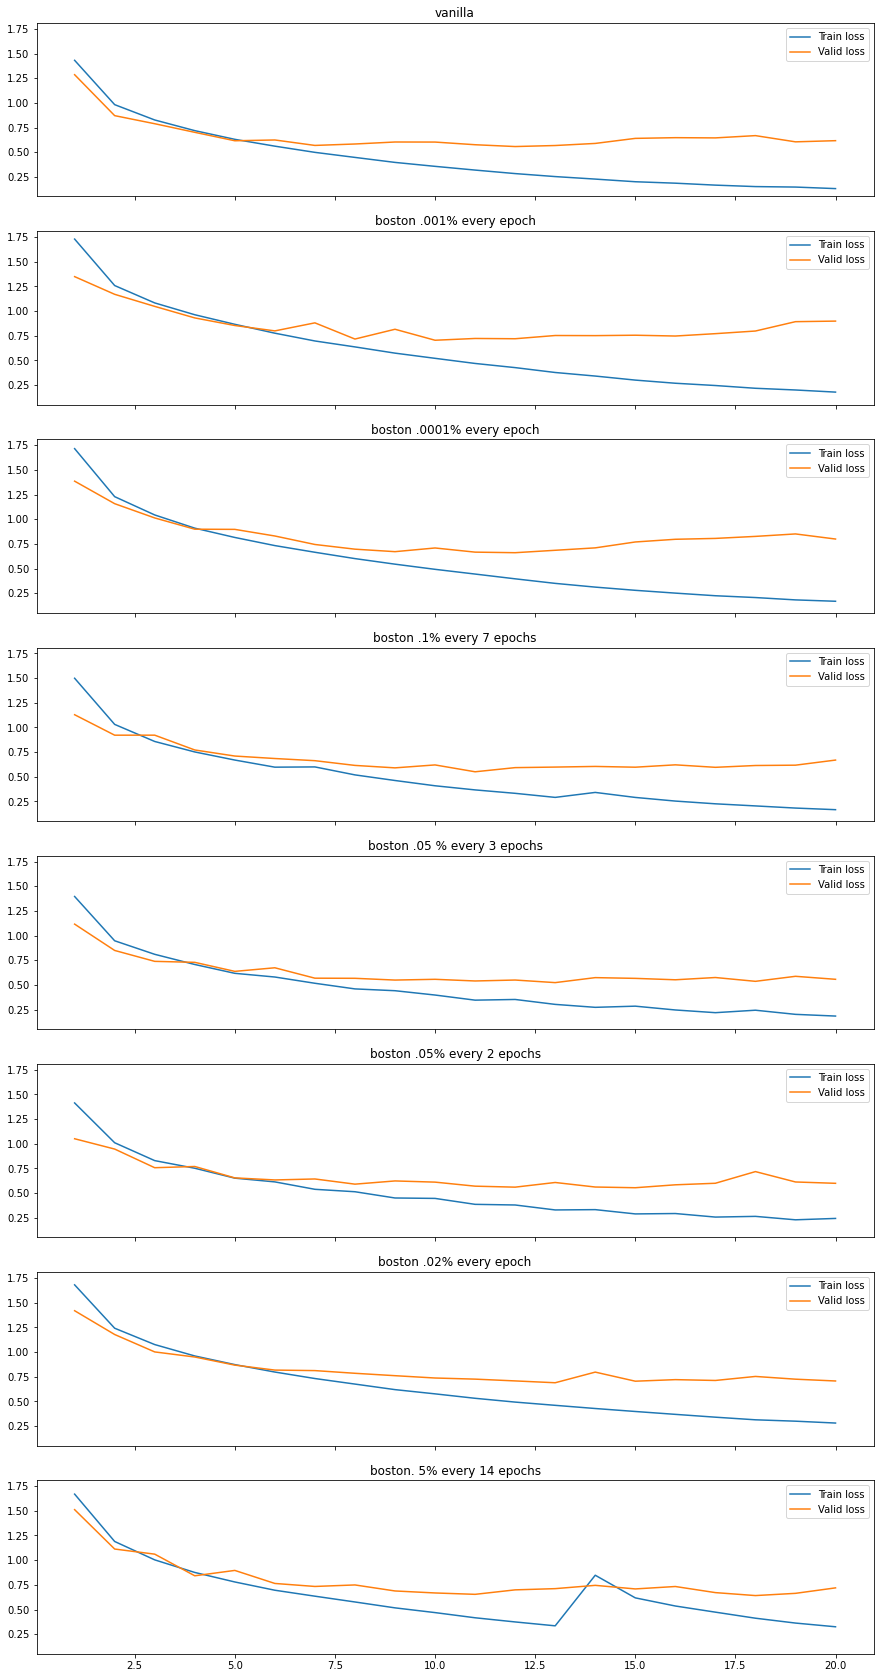

In [67]:
fig, axs = plt.subplots(8, sharex=True, sharey = True)
fig.set_figheight(30)
fig.set_figwidth(15)
for x in range(8):
    axs[x].set_title(labels[x])
    axs[x].plot(x_, results[x]['Train_loss'], label = 'Train loss')
    axs[x].plot(x_, results[x]['Valid_loss'], label = 'Valid loss')
    axs[x].legend()


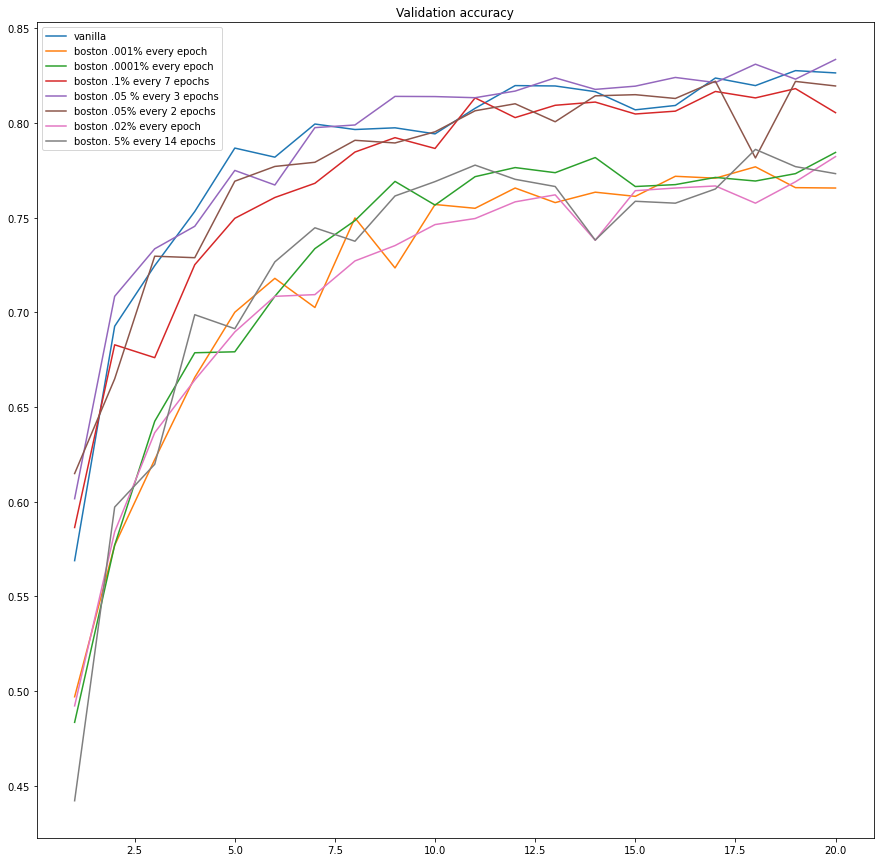

In [61]:
fig1, axs2 = plt.subplots(1)
axs2.set_title('Validation accuracy')
fig1.set_figheight(15)
fig1.set_figwidth(15)
for x in range(8):
    axs2.plot(x_, results[x]['Valid_accuracy'], label = labels[x])
axs2.legend()


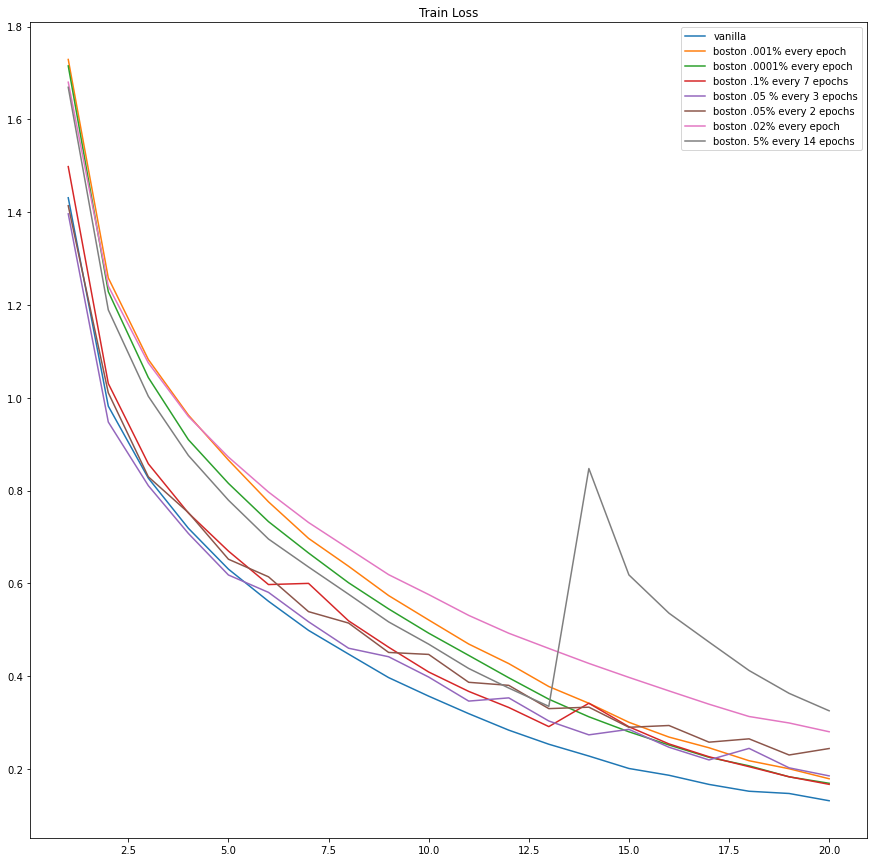

In [71]:
fig2, axs3 = plt.subplots(1)
axs3.set_title('Train Loss')
fig2.set_figheight(15)
fig2.set_figwidth(15)
for x in range(8):
    axs3.plot(x_, results[x]['Train_loss'], label = labels[x])
axs3.legend()


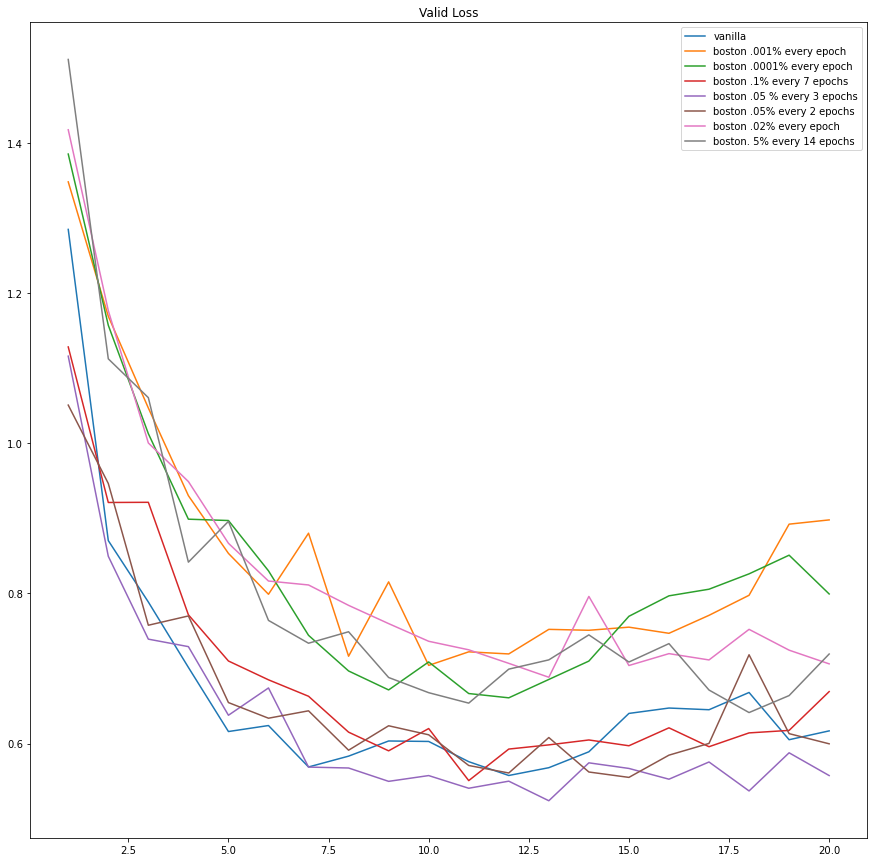

In [72]:
fig3, axs4 = plt.subplots(1)
axs4.set_title('Valid Loss')
fig3.set_figheight(15)
fig3.set_figwidth(15)
for x in range(8): 
    axs4.plot(x_, results[x]['Valid_loss'], label = labels[x])
    axs4.legend()

#
# These results show that while SIW dropout is not effective at reducing training loss it may be effective
# in helping the network generalize better. This can be seen by comparing both the validation losses and 
# validation accuracy of the vanilla network (blue) and the network with a .05% chance of SIW dropout 
# every three epochs (purple). However this results may have been due to the randomness introduced in training.
# Further experimentation will be done below. 
#
# Curiously the network that had half of its weights set to zero at epoch 14 suffered only small setbacks to its
# validation loss and accuracy.